In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from keras.optimizers import AdamW
from tensorflow.keras.layers import BatchNormalization

# Loading and splitting the dataset

In [ ]:
(train_set, valid_set, test_set), (data_info)  = tfds.load(
    name="oxford_flowers102",
    split=["train", "validation", "test"],
    as_supervised=True,
    shuffle_files = True,
    with_info = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteQWY9KQ/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteQWY9KQ/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteQWY9KQ/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
valid_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
print(train_set.cardinality().numpy())

1020


In [ ]:
print(valid_set.cardinality().numpy())

1020


In [ ]:
print(test_set.cardinality().numpy())

6149


# Exploring the dataset

In [ ]:
data_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

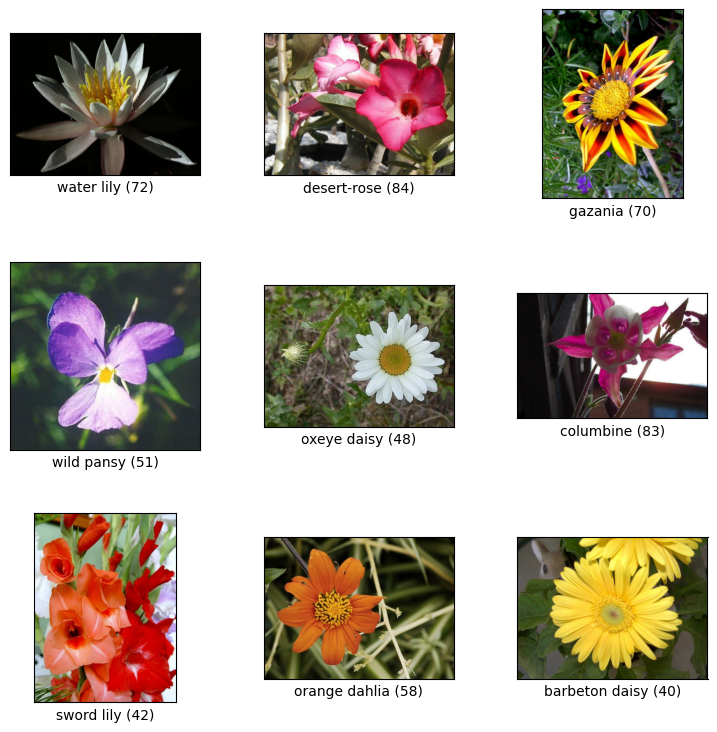

In [ ]:
fig = tfds.show_examples(train_set, tfds.builder('oxford_flowers102').info)

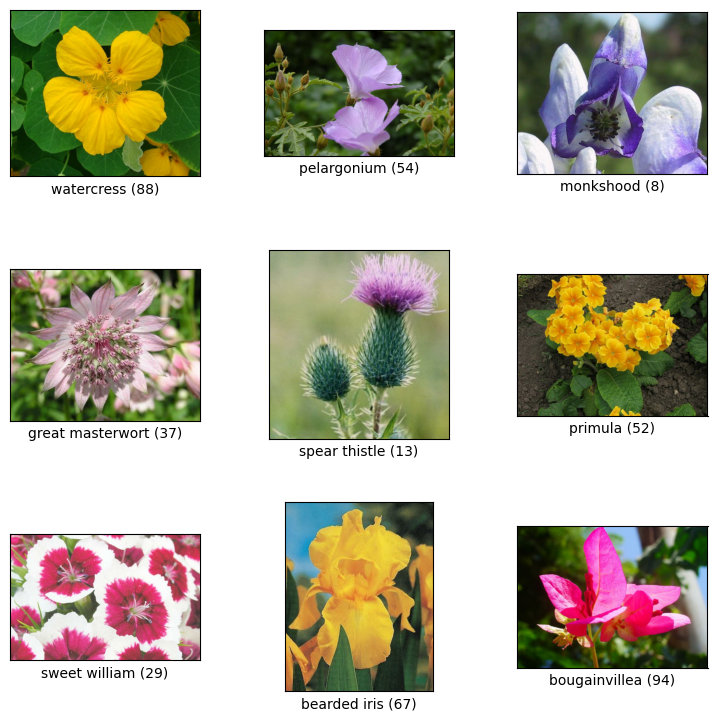

In [ ]:
fig2 = tfds.show_examples(valid_set, tfds.builder('oxford_flowers102').info)

# Data preparation

In [ ]:
image_size = (200, 200)
def normalize(image, label):
    normalized_image = tf.image.resize(image, image_size)
    normalized_image /= 255
    return normalized_image, label

In [ ]:
train_set = train_set.shuffle(2_000, seed=42).map(normalize).batch(32, drop_remainder=True).prefetch(1)
valid_set = valid_set.map(normalize).batch(32, drop_remainder=True).cache().prefetch(1)
test_set = test_set.map(normalize).batch(32, drop_remainder=True).cache().prefetch(1)
tf.random.set_seed(42)

# Building the model

In [ ]:
tf.random.set_seed(42)
model = Sequential()
model.add(Conv2D(input_shape=(200, 200, 3), filters=32,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(tf.keras.layers.GlobalAvgPool2D())
# model.add(Flatten())
model.add(tf.keras.layers.Dropout(0.75)),
# model.add(Dense(256, activation='relu')),
# model.add(tf.keras.layers.Dropout(0.8)),
# model.add(Dense(128, activation='relu')),
# model.add(tf.keras.layers.Dropout(0.5)),
model.add(Dense(102, activation='softmax'))

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=100,
                                                     restore_best_weights=True)

In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

In [ ]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 25, 25, 128)       0

# Training and evaluating it

In [ ]:
history = model.fit(train_set, epochs=1000,
                    validation_data=(valid_set), callbacks=[checkpoint_cb, early_stopping_cb])
score = model.evaluate(test_set)

Epoch 1/1000
31/31 [==============================] - 16s 105ms/step - loss: 4.6348 - accuracy: 0.0081 - val_loss: 4.6248 - val_accuracy: 0.0101
Epoch 2/1000
31/31 [==============================] - 3s 55ms/step - loss: 4.6256 - accuracy: 0.0101 - val_loss: 4.6210 - val_accuracy: 0.0101
Epoch 3/1000
31/31 [==============================] - 4s 56ms/step - loss: 4.6229 - accuracy: 0.0040 - val_loss: 4.6091 - val_accuracy: 0.0181
Epoch 4/1000
31/31 [==============================] - 3s 54ms/step - loss: 4.5949 - accuracy: 0.0151 - val_loss: 4.5669 - val_accuracy: 0.0161
Epoch 5/1000
31/31 [==============================] - 3s 53ms/step - loss: 4.5398 - accuracy: 0.0171 - val_loss: 4.4516 - val_accuracy: 0.0252
Epoch 6/1000
31/31 [==============================] - 3s 55ms/step - loss: 4.4514 - accuracy: 0.0202 - val_loss: 4.3585 - val_accuracy: 0.0353
Epoch 7/1000
31/31 [==============================] - 3s 53ms/step - loss: 4.3989 - accuracy: 0.0202 - val_loss: 4.2739 - val_accuracy: 0.04

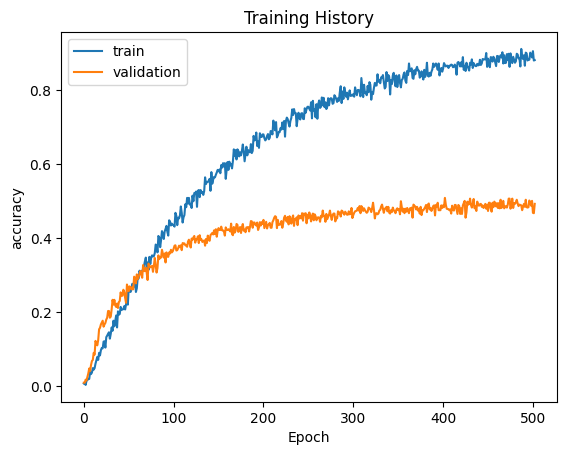

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title('Training History'),
plt.xlabel('Epoch'),
plt.ylabel('accuracy')
plt.show()

# Saving the model

In [ ]:
model.save('my_model_from_scratch.keras')

In [ ]:
# new_model = tf.keras.models.load_model('my_model_from_scratch.keras')